# 応用: 広告の効果はどれだけ持続するか

広告の効果測定を時変係数のモデルを用いて行う。

In [1]:
# パッケージの読み込み
library(KFAS)
library(forecast)
library(ggplot2)
library(ggfortify)
library(gridExtra)

# 図示設定
library(repr)
# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast



In [2]:
# シミュレーションデータの作成
n_sample <- 450

# 乱数の種
set.seed(10)

# 時間によって変化する広告の効果
true_reg_coef <- -log(1:50)*2 + 8

# ランダムウォークする水準値
mu <- cumsum(rnorm(n = n_sample, sd = 0.5)) + 15

# 水準値＋広告効果として状態をつくる
x <- mu + c(rep(0, 200), true_reg_coef, rep(0, 200))

In [7]:
# 観測誤差をつくる
obs_error <- rnorm(n = n_sample, sd = 2)

# 広告効果が入った売り上げデータ
sales_ad <- x + obs_error

In [8]:
# 説明変数としての広告フラグ
ad_flg <- numeric(n_sample)

ad_flg[201:250] <- 1

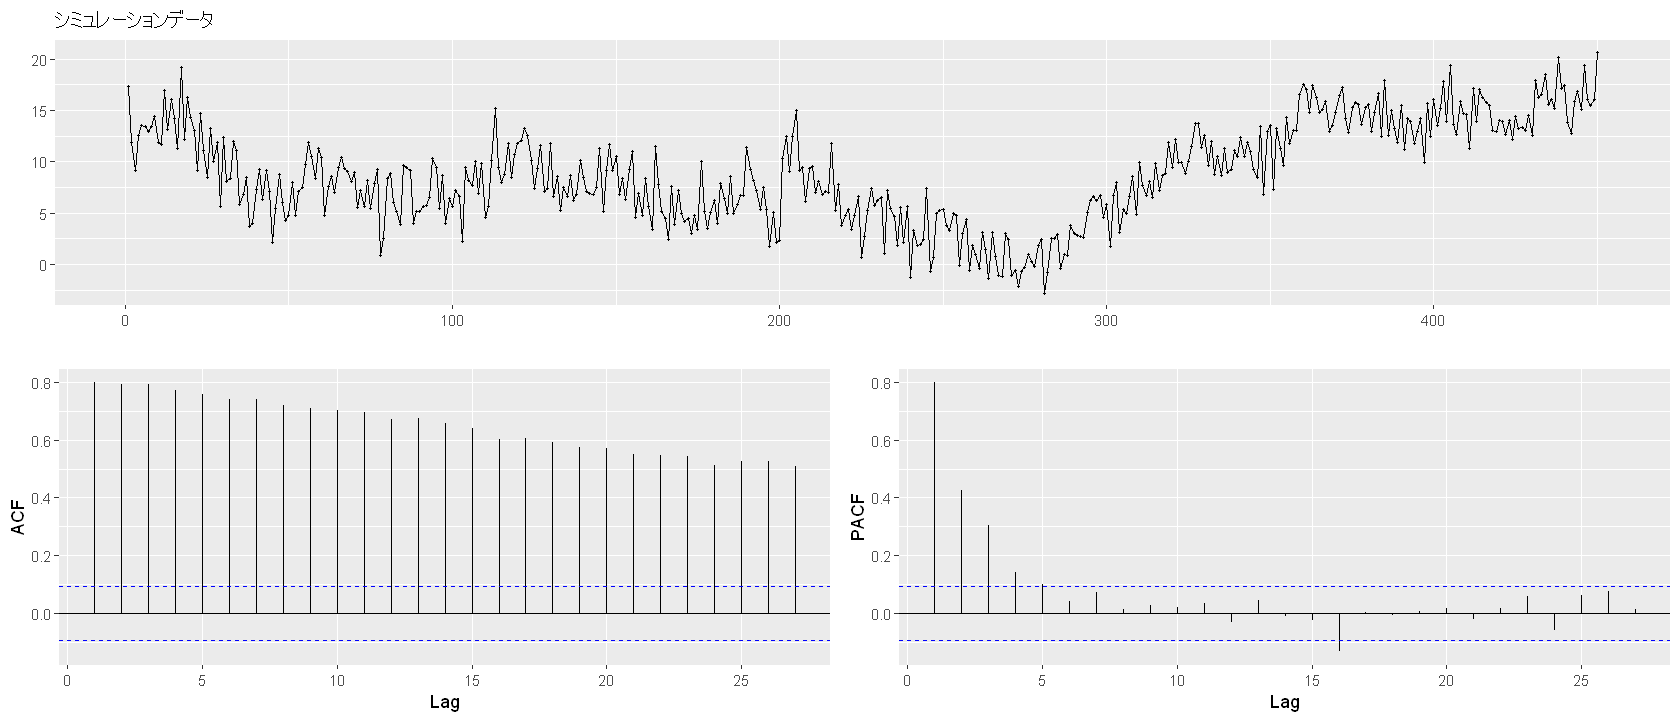

In [9]:
# 図示する
ggtsdisplay(ts(sales_ad), main="シミュレーションデータ")

## KFASによる時変係数モデル

In [10]:
# Step1: モデルの構造を決める
build_reg <- SSModel(
    H = NA, 
    sales_ad ~ 
        SSMtrend(degree = 1, Q = NA) +
        SSMregression( ~ ad_flg, Q = NA)
)

# Step2: モデルのパラメタ推定
fit_reg <- fitSSM(build_reg, inits = c(1, 1, 1))

# Step3,4: フィルタリング・スムージング
result_reg <- KFS(
    fit_reg$model,
    filtering = c("state", "mean"),
    smoothing = c("state", "mean")
)

## 変化する広告効果の図示

回帰係数の時間変化を図示して確認してみる。  
回帰係数は"states = regressoin"を指定することで得られる。

In [11]:
interval_coef <- predict(fit_reg$model, states="regression", interval="confidence", level = 0.95)

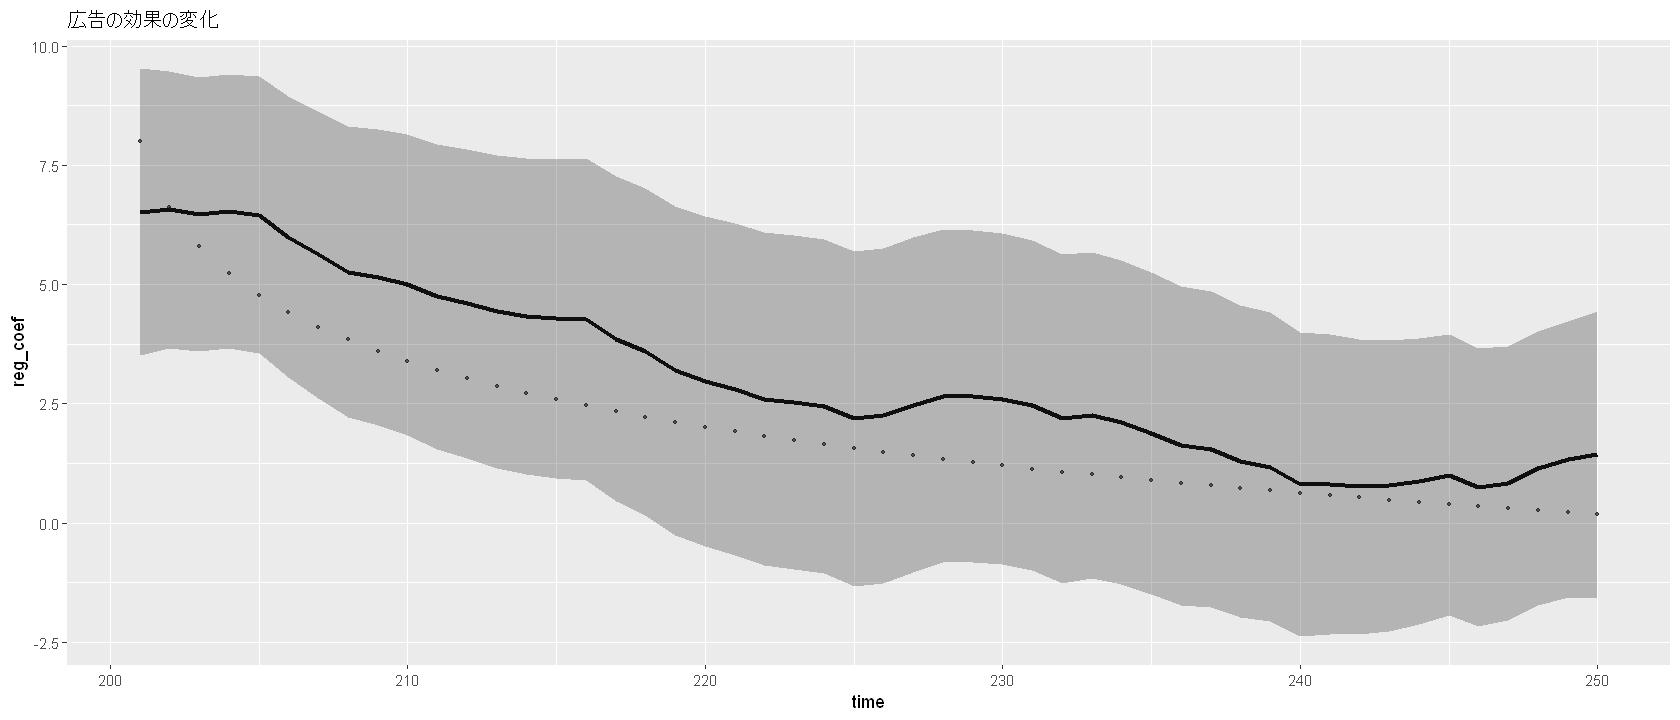

In [12]:
# 結果の図示
coef_df <- cbind(
    data.frame(time = 201:250, reg_coef = true_reg_coef),
    as.data.frame(interval_coef[201:250, ])
)

# 図示
ggplot(data = coef_df, aes(x = time, y = reg_coef)) + 
labs(title = "広告の効果の変化") + 
geom_point(alpha = 0.6, size = 0.9) + 
geom_line(aes(y = fit), size = 1.2) + 
geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3)